In [1]:
import geemap, ee, datetime as dt
import pandas as pd
import requests, time
import numpy as np

import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import tensorflow as tf
from glob import glob

In [2]:
import geopandas as gpd
from shapely.geometry import Point

### Creating TFRecord Dataset (image dataset)

In [3]:
ee.Initialize(project='stat-288-final-project-458620')

In [4]:
# MODIS land aerosol optical depth, daily 1 km
AOD = ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")

# MODIS 16-day NDVI, 16-day 1 km
NDVI = ee.ImageCollection("MODIS/MCD43A4_006_NDVI")

# VIIRS night-time lights, daily 1 km
VNTL = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')

BANDS_CORE = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI']        # always available
BAND_NTL   = 'avg_rad'   # monthly night‑lights
PATCH  = 32
SCALE  = 1000

In [5]:
# Print the first image's metadata and bands for each collection
def print_first_image_info(collection, name):
    first_img = collection.first()
    info = first_img.getInfo()
    print(f"--- {name} ---")
    print("ID:", info['id'])
    print("Bands:", [band['id'] for band in info['bands']])
    print("Properties:", list(info['properties'].keys()))
    print()

In [6]:
print_first_image_info(AOD, "AOD")
print_first_image_info(NDVI, "NDVI")
print_first_image_info(VNTL, "Night Lights")

--- AOD ---
ID: MODIS/061/MCD19A2_GRANULES/MCD19A2_A2000055_h00v08_061_2022153215218_01
Bands: ['Optical_Depth_047', 'Optical_Depth_055', 'AOD_Uncertainty', 'Column_WV', 'AOD_QA', 'Injection_Height', 'cosSZA', 'cosVZA', 'RelAZ', 'Scattering_Angle', 'Glint_Angle', 'FineModeFraction', 'AngstromExp_470-780']
Properties: ['SATELLITE', 'system:time_end', 'DESCRREVISION', 'system:time_start', 'ALGORITHMPACKAGENAME', 'LOCALVERSIONID', 'PGEVERSION', 'system:footprint', 'PRODUCTIONDATETIME', 'system:asset_size', 'ALGORITHMPACKAGEVERSION', 'system:index']

--- NDVI ---
ID: MODIS/MCD43A4_006_NDVI/2000_02_24
Bands: ['NDVI']
Properties: ['system:time_start', 'system:time_end', 'system:index']

--- Night Lights ---
ID: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG/20140101
Bands: ['avg_rad', 'cf_cvg']
Properties: ['system:time_start', 'system:footprint', 'system:time_end', 'system:asset_size', 'system:index']



In [7]:
def weekly_image(start):
    """Return a 4‑ or 5‑band image covering start–start+7 days."""
    start = ee.Date(start)
    end   = start.advance(7, 'day')
    
    # 1. MODIS aerosol + NDVI
    aod  = (AOD.filterDate(start, end)
                .select(['Optical_Depth_047', 'AOD_QA', 'Column_WV'])
                .median())
    ndvi = NDVI.filterDate(start, end).select('NDVI').median()
    base = aod.addBands(ndvi)

    # 2. Monthly night‑lights: pick the *calendar month* containing `start`
    ntl_month = VNTL.filterDate(start, start.advance(1, 'month')).first()
    
    img = ee.Image(ee.Algorithms.If(
        ntl_month,
        base.addBands(ntl_month.select(BAND_NTL).rename('NTL')),  # 5 bands
        base                                                     # 4 bands (no NTL)
    )).set({'system:time_start': start.millis()})
    
    return img

In [8]:
# weekly collection, convert to array bands
def weekly_collection(date_from, date_to):
    start = ee.Date(date_from); stop = ee.Date(date_to)
    n_weeks = stop.difference(start, 'week').round()
    imgs = ee.List.sequence(0, n_weeks.subtract(1)).map(
        lambda i: weekly_image(start.advance(i, 'week')))
    return ee.ImageCollection(imgs)

def to_array(img):
    # Convert every band to array version (whatever bands exist)
    return img.neighborhoodToArray(ee.Kernel.square(PATCH//2, 'pixels'))

ic_arrays = weekly_collection('2018-01-01', '2024-12-31').map(to_array)

In [9]:
df_delhi = pd.read_csv('data/delhi_weekly_pm25.csv')
df_lagos = pd.read_csv('data/lagos_weekly_pm25.csv')
df_bangkok = pd.read_csv('data/bangkok_weekly_pm25.csv')
df_accra = pd.read_csv('data/accra_weekly_pm25.csv')
df_taipei = pd.read_csv('data/taipei_weekly_pm25.csv')

In [12]:
# Create one point per sensor
def df_to_fc(df, city_tag):
    """
    Convert weekly DataFrame -> one‑point‑per‑sensor FeatureCollection.
    Keeps 'sid' as a property and adds a 'city' tag.
    """
    # 1. Get one row per sensor
    sensors = (df[["sid", "latitude", "longitude"]]
               .drop_duplicates())

    # 2. Build a GeoDataFrame with shapely Points
    gdf = gpd.GeoDataFrame(
        sensors,
        geometry=[Point(xy) for xy in zip(sensors.longitude, sensors.latitude)],
        crs="EPSG:4326"
    )

    # 3. Convert to Earth‑Engine FeatureCollection
    fc = geemap.gdf_to_ee(gdf, geodesic=False)

    # 4. Add a 'city' property to every feature
    fc = fc.map(lambda f: f.set({"city": city_tag}))

    return fc

In [11]:
fc_delhi = df_to_fc(df_delhi, "delhi")
fc_lagos = df_to_fc(df_lagos, "lagos")
fc_bangkok = df_to_fc(df_bangkok, "bangkok")
fc_accra = df_to_fc(df_accra, "accra")
print("Delhi sensors:", fc_delhi.size().getInfo())
print("Lagos sensors:", fc_lagos.size().getInfo())
print("Bangkok sensors:", fc_bangkok.size().getInfo())
print("Accra sensors:", fc_accra.size().getInfo())

Delhi sensors: 52
Lagos sensors: 1
Bangkok sensors: 59
Accra sensors: 23


In [13]:
fc_taipei = df_to_fc(df_taipei, "taipei")
print("Taipei sensors:", fc_taipei.size().getInfo())

Taipei sensors: 47


In [14]:
PATCH  = 32                              # pixels (≈ 32 km @ 1‑km MODIS)
SCALE  = 1000                            # meters
kernel = ee.Kernel.square(PATCH // 2, "pixels")

In [15]:
def weekly_samples(img, fc_points):
    return img.sampleRegions(
        collection   = fc_points,
        scale        = SCALE,
        tileScale    = 4,
        geometries   = True
    ).map(lambda f: f.set('week_ms', img.date().millis()))

In [14]:
samples_delhi = ic_arrays.map(lambda img: weekly_samples(img, fc_delhi)).flatten()
samples_lagos = ic_arrays.map(lambda img: weekly_samples(img, fc_lagos)).flatten()
samples_bangkok = ic_arrays.map(lambda img: weekly_samples(img, fc_bangkok)).flatten()
samples_accra = ic_arrays.map(lambda img: weekly_samples(img, fc_accra)).flatten()

In [16]:
samples_taipei = ic_arrays.map(lambda img: weekly_samples(img, fc_taipei)).flatten()

In [15]:
# # Get the size of the samples_delhi FeatureCollection
# print("Delhi samples size:", samples_delhi.size().getInfo())
# print("Lagos samples size:", samples_lagos.size().getInfo())
# print("Bangkok samples size:", samples_bangkok.size().getInfo())
# print("Accra samples size:", samples_accra.size().getInfo())

Delhi samples size: 11278


KeyboardInterrupt: 

In [ ]:
# ee.batch.Export.table.toDrive(
#     samples_delhi,
#     description='delhi_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_lagos,
#     description='lagos_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_bangkok,
#     description='bangkok_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_accra,
#     description='accra_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

In [17]:
ee.batch.Export.table.toDrive(
    samples_taipei,
    description='taipei_patches32',
    fileFormat='TFRecord',
    selectors=None  # export all properties
).start()

In [21]:
# Find the date range of the delhi_patches32 and lagos_patches32 TFRecord files
def get_date_range(filename):
    raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")
    records_list = list(raw_dataset)
    
    # Get the first record
    first_example = tf.train.Example()
    first_example.ParseFromString(records_list[0].numpy())
    first_week_ms = first_example.features.feature['week_ms'].float_list.value[0]
    first_date = dt.datetime.fromtimestamp(first_week_ms/1000).strftime('%Y-%m-%d')
    
    # Get the last record
    last_example = tf.train.Example()
    last_example.ParseFromString(records_list[-1].numpy())
    last_week_ms = last_example.features.feature['week_ms'].float_list.value[0]
    last_date = dt.datetime.fromtimestamp(last_week_ms/1000).strftime('%Y-%m-%d')
    
    return first_date, last_date, len(records_list)

# Delhi patches
delhi_file = "data/delhi_patches32.tfrecord.gz"
delhi_start, delhi_end, delhi_count = get_date_range(delhi_file)
print(f"Delhi patches: {delhi_count} records from {delhi_start} to {delhi_end}")

# Lagos patches (if file exists)
lagos_file = "data/lagos_patches32.tfrecord.gz"
try:
    lagos_start, lagos_end, lagos_count = get_date_range(lagos_file)
    print(f"Lagos patches: {lagos_count} records from {lagos_start} to {lagos_end}")
except (FileNotFoundError, IndexError):
    print("Lagos patches file not found or empty")

Delhi patches: 11278 records from 2017-12-31 to 2024-12-22
Lagos patches: 106 records from 2017-12-31 to 2024-12-22


2025-05-10 17:56:06.749133: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Selected random record 7038 of 11278
Record metadata:
Week: 2023-01-22 (timestamp: 1674431954944.0)
Sensor ID: 17790.0
Location: (28.68117332458496, 77.30252075195312)


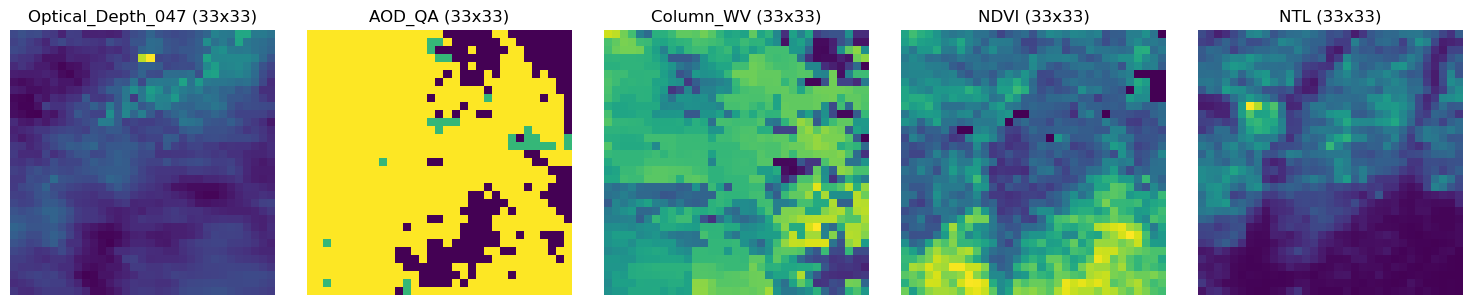

In [54]:
# Read the last record
filename = "data/delhi_patches32.tfrecord.gz"
raw_dataset = tf.data.TFRecordDataset(filename, compression_type="GZIP")
# Convert to list to get a random record
records_list = list(raw_dataset)
if records_list:
    # Choose a random record
    random_index = np.random.randint(0, len(records_list))
    raw_record = records_list[random_index]
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(f"Selected random record {random_index} of {len(records_list)}")
else:
    example = tf.train.Example()

# Print metadata about the record
print("Record metadata:")
if 'week_ms' in example.features.feature:
    week_ms = example.features.feature['week_ms'].float_list.value[0]
    week_date = dt.datetime.fromtimestamp(week_ms/1000).strftime('%Y-%m-%d')
    print(f"Week: {week_date} (timestamp: {week_ms})")
else:
    print("Week timestamp not found")

if 'sid' in example.features.feature:
    sid = example.features.feature['sid'].float_list.value[0]
    print(f"Sensor ID: {sid}")
else:
    print("Sensor ID not found")

if 'latitude' in example.features.feature and 'longitude' in example.features.feature:
    lat = example.features.feature['latitude'].float_list.value[0]
    lon = example.features.feature['longitude'].float_list.value[0]
    print(f"Location: ({lat}, {lon})")
else:
    print("Location coordinates not found")

# List the bands you want to visualize
bands = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI', 'NTL']  # adjust as needed

# Extract and plot each band
fig, axs = plt.subplots(1, len(bands), figsize=(15, 3))
for i, band in enumerate(bands):
    feature = example.features.feature.get(band)
    if feature is None:
        axs[i].set_title(f"{band}\n(Missing)")
        axs[i].axis('off')
        continue
    
    # Try float_list first, then bytes_list
    if feature.float_list.value:
        # Calculate the actual dimensions - sqrt of the array size
        arr_size = len(feature.float_list.value)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = np.array(feature.float_list.value).reshape(dim, dim)
    elif feature.bytes_list.value:
        # For bytes, also calculate dimensions dynamically
        arr = np.frombuffer(feature.bytes_list.value[0], dtype=np.uint16)
        arr_size = len(arr)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = arr.reshape(dim, dim).astype(np.float32)
    else:
        axs[i].set_title(f"{band}\n(Unknown type)")
        axs[i].axis('off')
        continue
    
    axs[i].imshow(arr, cmap='viridis')
    axs[i].set_title(f"{band} ({dim}x{dim})")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### Train & Test Set Setup (Merging)

In [23]:
def load_tfrecord_data(tfrecord_path):
    """
    Load TFRecord data from the given path. Expects TFRecords with features:
      - 'sid': Sensor ID (float)
      - 'week_ms': Week start timestamp in milliseconds (float)
      - 'Optical_Depth_047': AOD values (float_list)
      - 'AOD_QA': Quality assurance values (float_list)
      - 'NDVI': Normalized Difference Vegetation Index values (float_list)
      - 'Column_WV': Column water vapor values (float_list)
      - 'longitude', 'latitude': Coordinates (float)
      - 'city': City name (bytes)
    Returns:
      A pandas DataFrame with columns ['sid', 'week_ms', 'patch'].
      'sid' is int, 'week_ms' is int, and 'patch' is a numpy array of shape (32, 32, 4)
      where the 4 channels are [Optical_Depth_047, AOD_QA, NDVI, Column_WV].
    """
    PATCH = 33
    bands = ['Optical_Depth_047', 'AOD_QA', 'NDVI', 'Column_WV']
    data = []
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        features = example.features.feature
        
        # Extract sensor ID
        sid = int(features['sid'].float_list.value[0])
        
        # Extract week timestamp (ms since epoch)
        week_ms = int(features['week_ms'].float_list.value[0])
        
        # Extract coordinates
        longitude = features['longitude'].float_list.value[0]
        latitude = features['latitude'].float_list.value[0]
        
        # Extract the four bands to create the patch
        patch = []
        for band in bands:
            arr = features[band].float_list.value
            if len(arr) == PATCH * PATCH:
                arr = np.array(arr).reshape(PATCH, PATCH)
            else:
                arr = np.zeros((PATCH, PATCH), dtype=np.float32)
            patch.append(arr)
        patch = np.stack(patch, axis=-1)
        
        # Append to list
        data.append({
            'sid': sid, 
            'week_ms': week_ms, 
            'longitude': longitude,
            'latitude': latitude,
            'patch': patch
        })
        
        # Optional: extract city if needed
        if 'city' in features:
            data[-1]['city'] = features['city'].bytes_list.value[0].decode('utf-8')
            
    return pd.DataFrame(data)

In [24]:
def load_csv_data(csv_path):
    """
    Load the OpenAQ weekly PM2.5 CSV from the given path.
    Returns:
      A pandas DataFrame with columns ['sid', 'week', 'pm25_mean', 'year', 'week_ms'].
      - 'sid' is int
      - 'week' is the week start date string (YYYY-MM-DD)
      - 'pm25_mean' is float
      - 'year' is int (year of the week)
      - 'week_ms' is int (timestamp in ms for the week start)
    """
    df = pd.read_csv(csv_path)
    # Ensure correct dtypes
    if 'sid' in df.columns:
        df['sid'] = df['sid'].astype(int)
    if 'pm25_mean' in df.columns:
        df['pm25_mean'] = df['pm25_mean'].astype(float)
    # Parse week dates to datetime and extract year and timestamp
    if 'week' in df.columns:
        df['date'] = pd.to_datetime(df['week'])
    else:
        # If no 'week' column (unlikely in our case), try 'week_ms'
        if 'week_ms' in df.columns:
            df['date'] = pd.to_datetime(df['week_ms'], unit='ms')
        else:
            raise ValueError("CSV must contain 'week' or 'week_ms' column for dates.")
    df['year'] = df['date'].dt.year
    # Convert week start to milliseconds timestamp (epoch)
    # Use floor division by 1e6 because pandas datetime is in ns.
    df['week_ms'] = (df['date'].astype(np.int64) // 10**6).astype(np.int64)
    return df[['sid', 'week', 'pm25_mean', 'year', 'week_ms']]

In [25]:
def build_cnn_model(input_shape=(PATCH,PATCH,4)):
    inp = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32,3,activation='relu')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    out = tf.keras.layers.Dense(1)(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss='mse', metrics=['mae'])
    return m

In [43]:
def train_model(model, X_tr, y_tr, X_va, y_va):
    """
    Train the CNN model on Delhi + Bangkok training data and evaluate on validation data.
    Early stopping is used to prevent overfitting.
    Returns the trained model.
    """
    es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_va,y_va),
        epochs=30, batch_size=32,
        callbacks=[es],
        verbose=2
    )
    return model

In [55]:
# File paths
delhi_tf_path = "data/delhi_patches32.tfrecord.gz"
lagos_tf_path = "data/lagos_patches32.tfrecord.gz"
bangkok_tf_path = "data/bangkok_patches32.tfrecord.gz"
accra_tf_path = "data/accra_patches32.tfrecord.gz"
taipei_tf_path = "data/taipei_patches32.tfrecord.gz"

delhi_csv_path = "data/delhi_weekly_pm25.csv"
lagos_csv_path = "data/lagos_weekly_pm25.csv"
bangkok_csv_path = "data/bangkok_weekly_pm25.csv"
accra_csv_path = "data/accra_weekly_pm25.csv"
taipei_csv_path = "data/taipei_weekly_pm25.csv"

In [56]:
# Load TFRecord and CSV data
print("Loading Delhi TFRecord data...")
delhi_patches = load_tfrecord_data(delhi_tf_path)
print(f"Loaded {len(delhi_patches)} Delhi patch samples.")
print("Loading Lagos TFRecord data...")
lagos_patches = load_tfrecord_data(lagos_tf_path)
print(f"Loaded {len(lagos_patches)} Lagos patch samples.")
print("Loading Bangkok TFRecord data...")
bangkok_patches = load_tfrecord_data(bangkok_tf_path)
print(f"Loaded {len(bangkok_patches)} Bangkok patch samples.")
print("Loading Accra TFRecord data...")
accra_patches = load_tfrecord_data(accra_tf_path)
print(f"Loaded {len(accra_patches)} Accra patch samples.")
print("Loading Taipei TFRecord data...")
taipei_patches = load_tfrecord_data(taipei_tf_path)
print(f"Loaded {len(taipei_patches)} Taipei patch samples.")


print("Loading Delhi labels CSV...")
delhi_labels = load_csv_data(delhi_csv_path)
print(f"Loaded {len(delhi_labels)} Delhi label entries.")
print("Loading Lagos labels CSV...")
lagos_labels = load_csv_data(lagos_csv_path)
print(f"Loaded {len(lagos_labels)} Lagos label entries.")
print("Loading Bangkok labels CSV...")
bangkok_labels = load_csv_data(bangkok_csv_path)
print(f"Loaded {len(bangkok_labels)} Bangkok label entries.")
print("Loading Accra labels CSV...")
accra_labels = load_csv_data(accra_csv_path)
print(f"Loaded {len(accra_labels)} Accra label entries.")
print("Loading Taipei labels CSV...")
taipei_labels = load_csv_data(taipei_csv_path)
print(f"Loaded {len(taipei_labels)} Taipei label entries.")


Loading Delhi TFRecord data...
Loaded 11278 Delhi patch samples.
Loading Lagos TFRecord data...
Loaded 106 Lagos patch samples.
Loading Bangkok TFRecord data...


2025-05-10 18:04:11.074773: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loaded 8059 Bangkok patch samples.
Loading Accra TFRecord data...
Loaded 3458 Accra patch samples.
Loading Taipei TFRecord data...
Loaded 9146 Taipei patch samples.
Loading Delhi labels CSV...
Loaded 3975 Delhi label entries.
Loading Lagos labels CSV...
Loaded 50 Lagos label entries.
Loading Bangkok labels CSV...
Loaded 10075 Bangkok label entries.
Loading Accra labels CSV...
Loaded 726 Accra label entries.
Loading Taipei labels CSV...
Loaded 4902 Taipei label entries.


In [57]:
# Add week column to patches
delhi_patches['week'] = pd.to_datetime(delhi_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
lagos_patches['week'] = pd.to_datetime(lagos_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
bangkok_patches['week'] = pd.to_datetime(bangkok_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
accra_patches['week'] = pd.to_datetime(accra_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')
taipei_patches['week'] = pd.to_datetime(taipei_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')

In [58]:
# Combining Delhi + Bangkok to make a larger training set
train_patches = pd.concat([delhi_patches, bangkok_patches], ignore_index=True)
train_labels = pd.concat([delhi_labels, bangkok_labels], ignore_index=True)

In [59]:
# Use isoyear and isoweek to merge patches and labels

for df in [train_patches, train_labels, lagos_patches, lagos_labels, accra_patches, accra_labels, taipei_patches, taipei_labels]:
    df['week_dt'] = pd.to_datetime(df['week'], errors='coerce')
    df['iso_year'] = df['week_dt'].dt.isocalendar().year
    df['iso_week'] = df['week_dt'].dt.isocalendar().week

In [60]:
# Training data
train_merged = pd.merge(
    train_patches, train_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# Accra data: for evaluation
accra_merged = pd.merge(
    accra_patches, accra_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# Lagos data: for evaluation
lagos_merged = pd.merge(
    lagos_patches, lagos_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# Taipei data: for evaluation
taipei_merged = pd.merge(
    taipei_patches, taipei_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)


In [61]:
print(len(train_merged))
print(len(accra_merged))
print(len(lagos_merged))
print(len(taipei_merged))
train_merged

6160
428
13
2485


,sid,week_ms_x,longitude,latitude,patch,city,week_x,week_dt_x,iso_year,iso_week,week_y,pm25_mean,year,week_ms_y,week_dt_y
0,35,1514764763136,77.186935,28.563263,"[[[795.0, 1280.0, 0.22233502566814423, 812.0],...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,259.000000,2017,1514246400000,2017-12-26
1,388,1514764763136,77.200500,28.634100,"[[[824.0, 1280.0, 0.30079999566078186, 798.0],...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,377.000000,2017,1514246400000,2017-12-26
2,13860,1514764763136,77.158096,28.651699,"[[[803.0, 1282.0, 0.0, 831.5], [814.0, 1280.0,...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,349.000000,2017,1514246400000,2017-12-26
3,13861,1514764763136,77.249397,28.623501,"[[[725.0, 1280.0, 0.0, 799.0], [801.5, 1057.0,...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,235.500000,2017,1514246400000,2017-12-26
4,13900,1514764763136,77.313774,28.410122,"[[[945.0, 1283.0, 0.5579235553741455, 928.5], ...",delhi,2017-12-31,2017-12-31,2017,52,2017-12-26,260.000000,2017,1514246400000,2017-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,1304438,1734911983616,100.732079,13.813578,"[[[291.0, 1283.0, 0.0, 2019.0], [298.0, 1281.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,32.800000,2024,1734393600000,2024-12-17
6156,1304524,1734911983616,100.646011,13.779873,"[[[348.5, 1282.0, 0.0, 2214.0], [441.5, 1282.5...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,29.414286,2024,1734393600000,2024-12-17
6157,1305020,1734911983616,100.474373,13.729431,"[[[371.5, 1280.0, 0.0, 2250.0], [342.0, 1281.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,37.785714,2024,1734393600000,2024-12-17
6158,5077771,1734911983616,100.486565,13.727622,"[[[357.0, 1281.0, 0.0, 2295.0], [369.0, 1280.0...",bangkok,2024-12-22,2024-12-22,2024,51,2024-12-17,37.428571,2024,1734393600000,2024-12-17


### CNN Training & Evaluation

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [63]:
# Split the data into training and test sets by random sampling (not by time)
# For Training Data (Delhi + Bangkok): 80% training, 20% validation
train_df, val_df = train_test_split(train_merged, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print(f"Delhi + BK data: {len(train_merged)} total samples")
print(f"Delhi + BK training: {len(train_df)} samples, Delhi + BK test: {len(val_df)} samples")

# Verify that the splits are random across time (not time-based)
print("\nDistribution of years in Delhi + BK training set:")
print(train_df['year'].value_counts().sort_index())
print("\nDistribution of years in Delhi + BK validation set:")
print(val_df['year'].value_counts().sort_index())


Delhi + BK data: 6160 total samples
Delhi + BK training: 4928 samples, Delhi + BK test: 1232 samples

Distribution of years in Delhi + BK training set:
year
2017       5
2018     290
2019     145
2020     499
2021     651
2022     659
2023    1326
2024    1353
Name: count, dtype: int64

Distribution of years in Delhi + BK validation set:
year
2018     92
2019     42
2020    129
2021    149
2022    163
2023    334
2024    323
Name: count, dtype: int64


In [101]:
sample_patch = train_df['patch'].iloc[0]
input_shape = sample_patch.shape  # e.g., (32, 32, 1) or (32, 32, 3)

model = build_cnn_model(input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 33, 33, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 31, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,305 (290.25 KB)

 Trainable params: 74,305 (290.25 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# Prepare X,y arrays
def df_to_xy(df):
    X = np.stack(df['patch'].values).astype(np.float32)
    y = df['pm25_mean'].values.astype(np.float32)
    return X,y

X_tr, y_tr = df_to_xy(train_df)
X_va, y_va = df_to_xy(val_df)

In [103]:
# Pre-train on Delhi + Bangkok
model = train_model(model, X_tr, y_tr, X_va, y_va)

Epoch 1/30
154/154 - 4s - 29ms/step - loss: 2233.7305 - mae: 26.1928 - val_loss: 1082.1135 - val_mae: 20.0270
Epoch 2/30
154/154 - 3s - 21ms/step - loss: 968.5158 - mae: 18.6781 - val_loss: 1040.3857 - val_mae: 18.4803
Epoch 3/30
154/154 - 3s - 19ms/step - loss: 968.2606 - mae: 18.8049 - val_loss: 1077.5952 - val_mae: 22.1357
Epoch 4/30
154/154 - 3s - 19ms/step - loss: 909.1191 - mae: 17.8762 - val_loss: 1014.8442 - val_mae: 18.9227
Epoch 5/30
154/154 - 3s - 19ms/step - loss: 896.8079 - mae: 17.9989 - val_loss: 992.9911 - val_mae: 17.5866
Epoch 6/30
154/154 - 3s - 20ms/step - loss: 855.7310 - mae: 17.0911 - val_loss: 933.8964 - val_mae: 17.7857
Epoch 7/30
154/154 - 3s - 21ms/step - loss: 864.1746 - mae: 17.5267 - val_loss: 914.8502 - val_mae: 17.1842
Epoch 8/30
154/154 - 4s - 24ms/step - loss: 868.3980 - mae: 17.4458 - val_loss: 1017.1364 - val_mae: 20.8146
Epoch 9/30
154/154 - 3s - 21ms/step - loss: 846.0502 - mae: 17.1191 - val_loss: 935.8951 - val_mae: 17.9844
Epoch 10/30
154/154 - 

In [104]:
# The 'model' variable is actually a History object returned from model.fit()
baseline_model = model

# Save the model locally
print("Saving model to disk...")
model_save_path = 'models/delhi_bangkok_pm25_cnn_model_v2.keras'  
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Saving model to disk...
Model saved to models/delhi_bangkok_pm25_cnn_model_v2.keras


### Evaluate!

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Delhi Test → RMSE=49.69, R²=0.280
Bangkok Test → RMSE=11.32, R²=-0.193


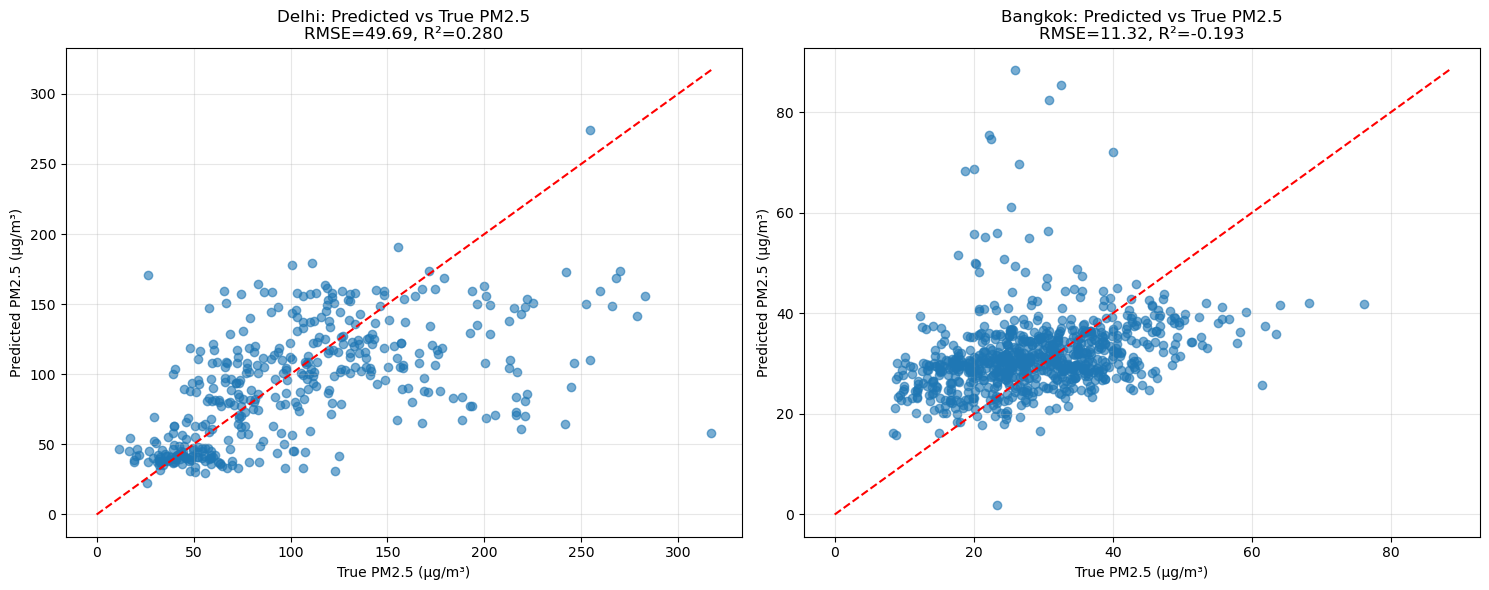

In [105]:
# Evaluate and plot predictions for Delhi and Bangkok separately

# First, separate Delhi and Bangkok data from the validation set
delhi_val_df = val_df[val_df['city'] == 'delhi'].reset_index(drop=True)
bangkok_val_df = val_df[val_df['city'] == 'bangkok'].reset_index(drop=True)

# Convert to X,y arrays
X_delhi, y_delhi = df_to_xy(delhi_val_df)
X_bangkok, y_bangkok = df_to_xy(bangkok_val_df)

# Make predictions
y_delhi_pred = model.predict(X_delhi).ravel()
y_bangkok_pred = model.predict(X_bangkok).ravel()

# Calculate metrics for Delhi
rmse_delhi = np.sqrt(mean_squared_error(y_delhi, y_delhi_pred))
r2_delhi = r2_score(y_delhi, y_delhi_pred)
print(f"Delhi Test → RMSE={rmse_delhi:.2f}, R²={r2_delhi:.3f}")

# Calculate metrics for Bangkok
rmse_bangkok = np.sqrt(mean_squared_error(y_bangkok, y_bangkok_pred))
r2_bangkok = r2_score(y_bangkok, y_bangkok_pred)
print(f"Bangkok Test → RMSE={rmse_bangkok:.2f}, R²={r2_bangkok:.3f}")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Delhi predictions vs true values
ax1.scatter(y_delhi, y_delhi_pred, alpha=0.6)
ax1.plot([0, max(y_delhi.max(), y_delhi_pred.max())], 
         [0, max(y_delhi.max(), y_delhi_pred.max())], 
         'r--')
ax1.set_xlabel('True PM2.5 (μg/m³)')
ax1.set_ylabel('Predicted PM2.5 (μg/m³)')
ax1.set_title(f'Delhi: Predicted vs True PM2.5\nRMSE={rmse_delhi:.2f}, R²={r2_delhi:.3f}')
ax1.grid(True, alpha=0.3)

# Plot Bangkok predictions vs true values
ax2.scatter(y_bangkok, y_bangkok_pred, alpha=0.6)
ax2.plot([0, max(y_bangkok.max(), y_bangkok_pred.max())], 
         [0, max(y_bangkok.max(), y_bangkok_pred.max())], 
         'r--')
ax2.set_xlabel('True PM2.5 (μg/m³)')
ax2.set_ylabel('Predicted PM2.5 (μg/m³)')
ax2.set_title(f'Bangkok: Predicted vs True PM2.5\nRMSE={rmse_bangkok:.2f}, R²={r2_bangkok:.3f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [106]:
# Zero-shot evaluation on Accra, Lagos, Taipei
X_acc, y_acc = df_to_xy(accra_merged)
X_lagos, y_lagos = df_to_xy(lagos_merged)
X_taipei, y_taipei = df_to_xy(taipei_merged)

y1 = model.predict(X_acc).ravel()
rmse_accra = np.sqrt(mean_squared_error(y_acc,y1))
r2_accra  = r2_score(y_acc,y1)
print(f"Accra all data zero-shot → RMSE={rmse_accra:.2f}, R²={r2_accra:.3f}")

y2 = model.predict(X_lagos).ravel()
rmse_lagos = np.sqrt(mean_squared_error(y_lagos,y2))
r2_lagos  = r2_score(y_lagos,y2)
print(f"Lagos all data zero-shot → RMSE={rmse_lagos:.2f}, R²={r2_lagos:.3f}")

y3 = model.predict(X_taipei).ravel()
rmse_taipei = np.sqrt(mean_squared_error(y_taipei,y3))
r2_taipei  = r2_score(y_taipei,y3)
print(f"Taipei all data zero-shot → RMSE={rmse_taipei:.2f}, R²={r2_taipei:.3f}")

# Evaluate on Delhi/Bangkok test set for comparison
X_test, y_test = df_to_xy(val_df)
y_test_pred = model.predict(X_test).ravel()
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
print(f"Delhi/Bangkok Test → RMSE={rmse_test:.2f}, R²={r2_test:.3f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accra all data zero-shot → RMSE=23.08, R²=-1.897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Lagos all data zero-shot → RMSE=26.91, R²=-33.560
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Taipei all data zero-shot → RMSE=32.49, R²=-30.105
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Delhi/Bangkok Test → RMSE=30.25, R²=0.627


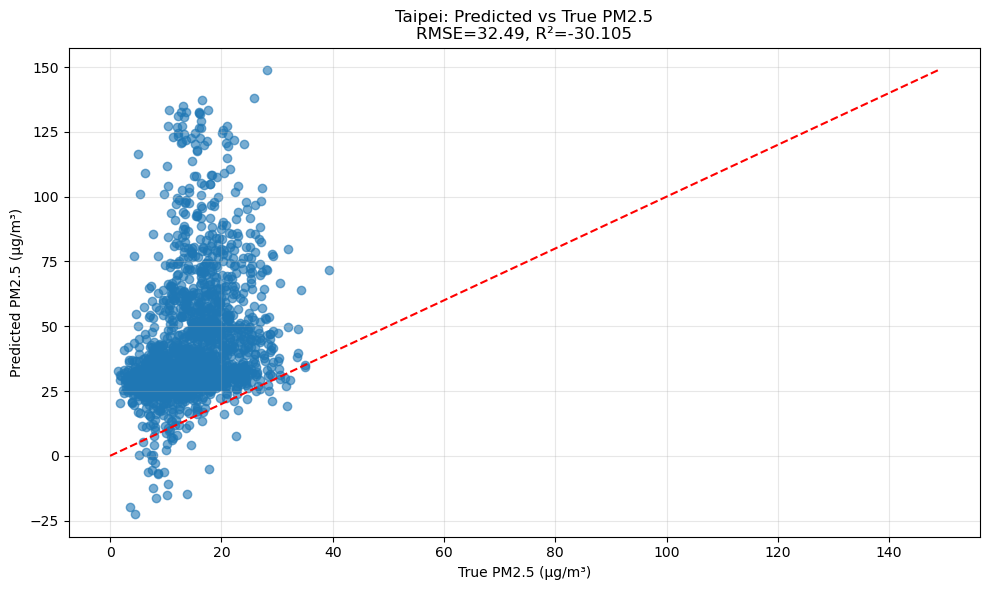

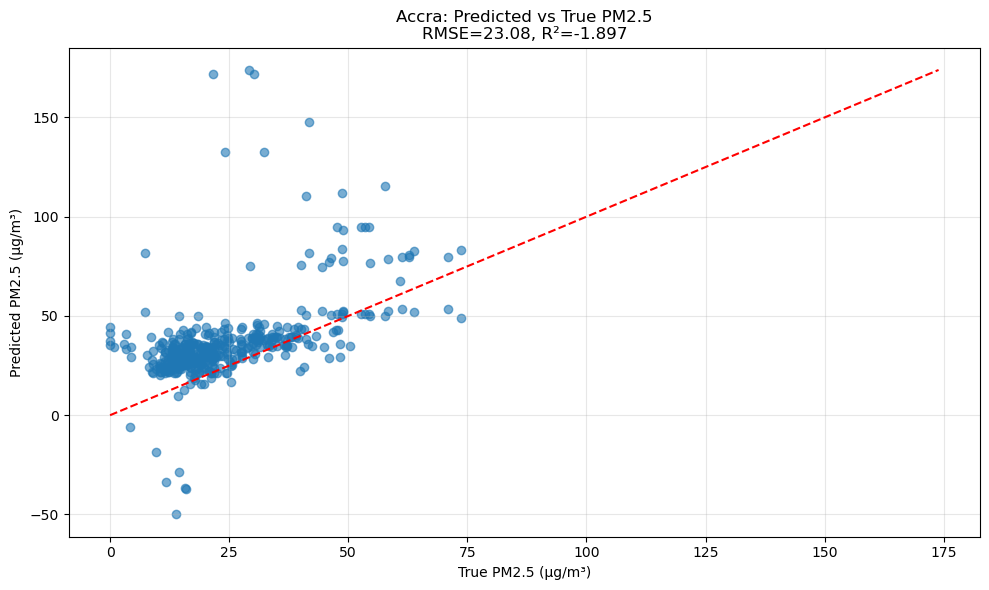

In [107]:
# Create a figure to plot Taipei predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_taipei, y3, alpha=0.6)
plt.plot([0, max(y_taipei.max(), y3.max())], 
         [0, max(y_taipei.max(), y3.max())], 
         'r--')
plt.xlabel('True PM2.5 (μg/m³)')
plt.ylabel('Predicted PM2.5 (μg/m³)')
plt.title(f'Taipei: Predicted vs True PM2.5\nRMSE={rmse_taipei:.2f}, R²={r2_taipei:.3f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a figure to plot Accra predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_acc, y1, alpha=0.6)
plt.plot([0, max(y_acc.max(), y1.max())], 
         [0, max(y_acc.max(), y1.max())], 
         'r--')
plt.xlabel('True PM2.5 (μg/m³)')
plt.ylabel('Predicted PM2.5 (μg/m³)')
plt.title(f'Accra: Predicted vs True PM2.5\nRMSE={rmse_accra:.2f}, R²={r2_accra:.3f}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [108]:
# assume `accra_df` has columns ['sid','week','pm25_mean','year', ...]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in splitter.split(accra_merged, accra_merged['year']):
    accra_train = accra_merged.iloc[train_idx].reset_index(drop=True)
    accra_test  = accra_merged.iloc[test_idx].reset_index(drop=True)

for train_idx, test_idx in splitter.split(taipei_merged, taipei_merged['year']):
    taipei_train = taipei_merged.iloc[train_idx].reset_index(drop=True)
    taipei_test  = taipei_merged.iloc[test_idx].reset_index(drop=True)

print("Accra train size:", len(accra_train))
print("Accra test size: ", len(accra_test))
print("Taipei train size:", len(taipei_train))
print("Taipei test size: ", len(taipei_test))

Accra train size: 342
Accra test size:  86
Taipei train size: 1988
Taipei test size:  497


In [86]:
fractions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fraction=0.01, N= 19 → RMSE=9.79
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fraction=0.02, N= 39 → RMSE=6.80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fraction=0.05, N= 99 → RMSE=6.32
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fraction=0.10, N=198 → RMSE=5.40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fraction=0.20, N=397 → RMSE=5.00
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fraction=0.50, N=994 → RMSE=4.78


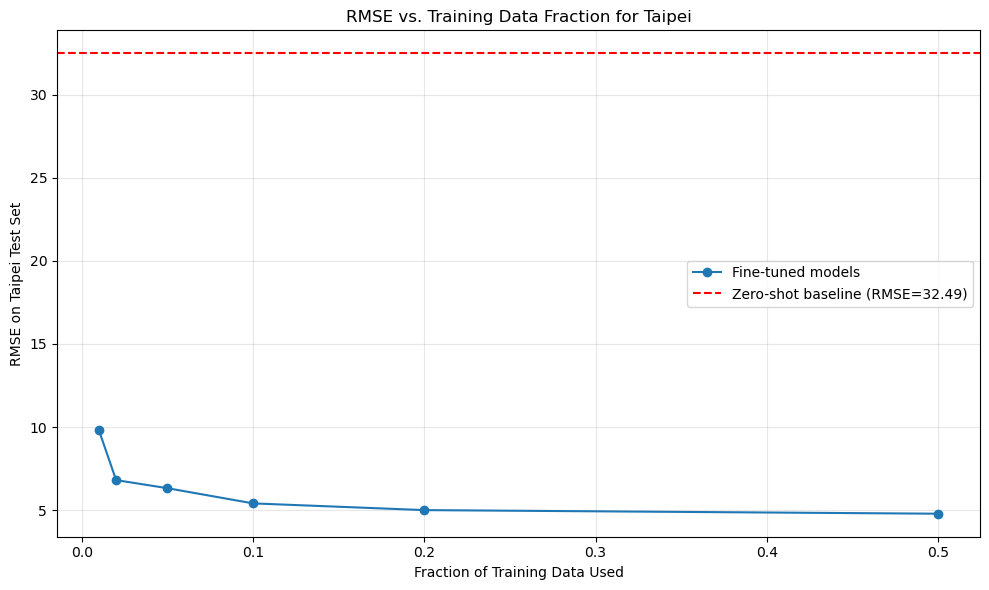

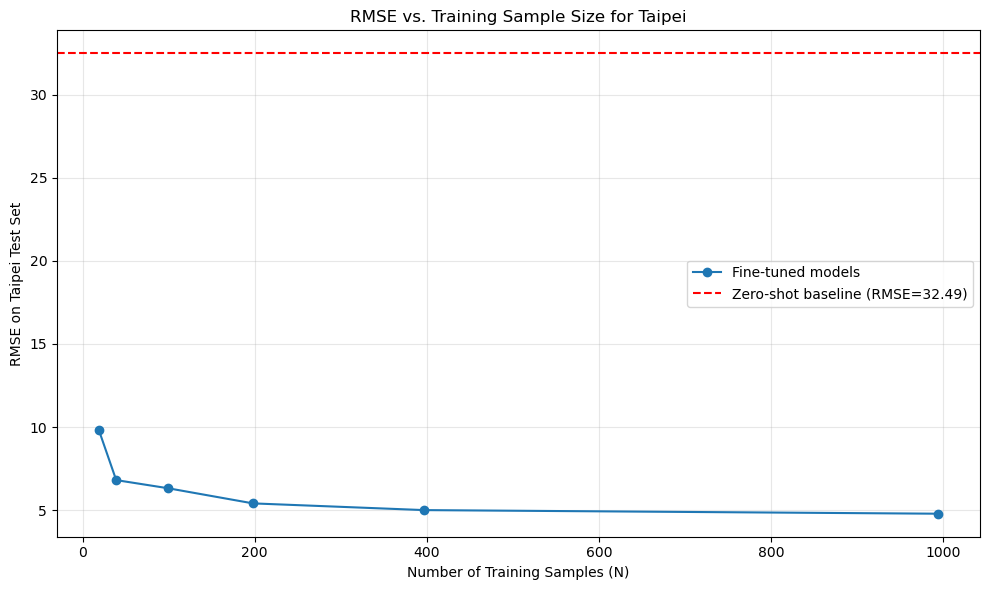

In [109]:
# Scarcity sweep on Taipei

taipei_results = []
for fraction in fractions:
    N = int(len(taipei_train) * fraction)
    if N < 5:  # Skip if too few samples
        continue
        
    sub = taipei_train.sample(n=N, random_state=42)
    Xn, yn = df_to_xy(sub)
    
    # Clone & freeze conv blocks
    m2 = tf.keras.models.clone_model(model)
    m2.set_weights(model.get_weights())
    
    # Freeze first 2 conv layers
    conv_layers = [l for l in m2.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in conv_layers[:2]:
        l.trainable = False
    
    # Compile and train the model
    m2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    m2.fit(Xn, yn, epochs=10, batch_size=8, verbose=0,
           sample_weight=np.ones_like(yn)*5)
    
    # Evaluate on test set
    X_taipei_test, y_taipei_test = df_to_xy(taipei_test)
    y_pred = m2.predict(X_taipei_test).ravel()
    rmse = np.sqrt(mean_squared_error(y_taipei_test, y_pred))
    
    taipei_results.append((fraction, N, rmse))
    print(f"Fraction={fraction:.2f}, N={N:3d} → RMSE={rmse:.2f}")

# Plot RMSE vs fraction
fractions_used = [r[0] for r in taipei_results]
N_values = [r[1] for r in taipei_results]
rmse_values = [r[2] for r in taipei_results]

plt.figure(figsize=(10, 6))
plt.plot(fractions_used, rmse_values, 'o-', label='Fine-tuned models')
plt.axhline(y=rmse_taipei, color='r', linestyle='--', 
            label=f'Zero-shot baseline (RMSE={rmse_taipei:.2f})')

plt.xlabel('Fraction of Training Data Used')
plt.ylabel('RMSE on Taipei Test Set')
plt.title('RMSE vs. Training Data Fraction for Taipei')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Also plot RMSE vs N
plt.figure(figsize=(10, 6))
plt.plot(N_values, rmse_values, 'o-', label='Fine-tuned models')
plt.axhline(y=rmse_taipei, color='r', linestyle='--', 
            label=f'Zero-shot baseline (RMSE={rmse_taipei:.2f})')

plt.xlabel('Number of Training Samples (N)')
plt.ylabel('RMSE on Taipei Test Set')
plt.title('RMSE vs. Training Sample Size for Taipei')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [110]:
# Scarcity sweep on Accra

accra_results = []

for fraction in fractions:
    # Calculate number of samples to use
    N = int(len(accra_train) * fraction)
    if N < 5: continue  # Skip if too few samples
    
    # Sample the training data
    sub = accra_train.sample(N, random_state=42)
    Xn, yn = df_to_xy(sub)
    
    # Clone & freeze conv blocks
    m2 = tf.keras.models.clone_model(model)
    m2.set_weights(model.get_weights())
    # Freeze first 2 conv layers
    conv_layers = [l for l in m2.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in conv_layers[:2]: l.trainable=False
    
    # Compile and train the model
    m2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    m2.fit(Xn, yn, epochs=10, batch_size=8, verbose=0,
           sample_weight=np.ones_like(yn)*5)
    
    # Evaluate on test set
    X_accra_test, y_accra_test = df_to_xy(accra_test)
    y_pred = m2.predict(X_accra_test).ravel()
    rmse = np.sqrt(mean_squared_error(y_accra_test, y_pred))
    
    accra_results.append((fraction, N, rmse))
    print(f"Fraction={fraction:.2f}, N={N:3d} → RMSE={rmse:.2f}")

# Compare to zero-shot RMSE
print("Zero-shot RMSE:", rmse_accra)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Fraction=0.02, N=  6 → RMSE=14.61
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fraction=0.05, N= 17 → RMSE=12.24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fraction=0.10, N= 34 → RMSE=10.70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fraction=0.20, N= 68 → RMSE=9.94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fraction=0.50, N=171 → RMSE=7.81
Zero-shot RMSE: 23.083704


The elbow point appears to be at 0.20 of training data (N=68) with RMSE=9.94
This suggests that using 20.00% of training data provides a good trade-off between
model performance and annotation effort for Accra.


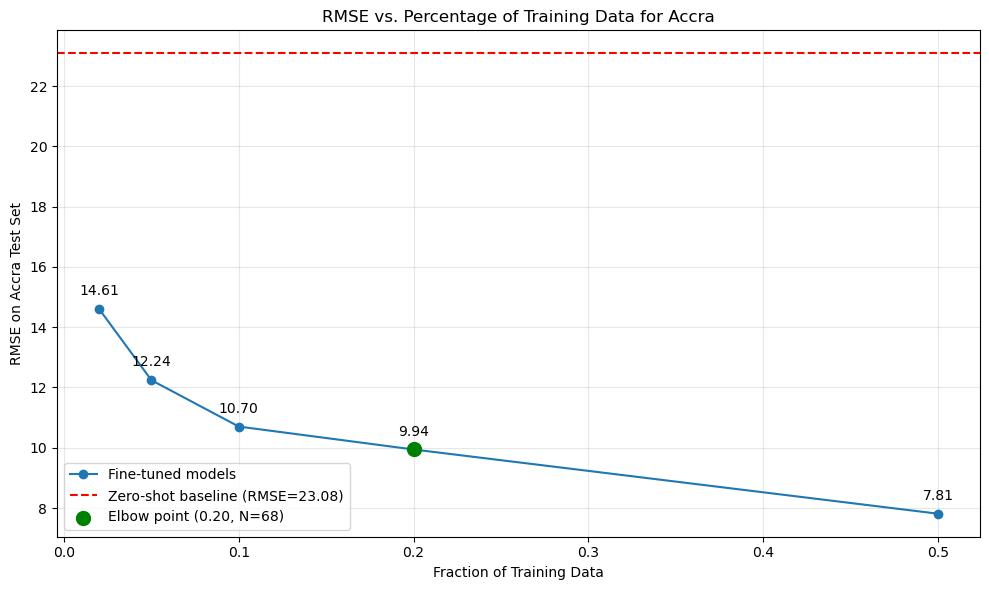

In [111]:
# Plot RMSE vs percentage of training data to find the "elbow" point

# Extract fraction and RMSE values from results
fractions = [r[0] for r in accra_results]  # Fraction of training data used
rmse_values = [r[2] for r in accra_results]  # RMSE values

# Add zero-shot baseline
plt.figure(figsize=(10, 6))
plt.plot(fractions, rmse_values, 'o-', label='Fine-tuned models')
plt.axhline(y=rmse_accra, color='r', linestyle='--', label=f'Zero-shot baseline (RMSE={rmse_accra:.2f})')

plt.xlabel('Fraction of Training Data')
plt.ylabel('RMSE on Accra Test Set')
plt.title('RMSE vs. Percentage of Training Data for Accra')
plt.grid(True, alpha=0.3)
plt.legend()

# Add RMSE annotations
for i, rmse in enumerate(rmse_values):
    plt.annotate(f'{rmse:.2f}', 
                 (fractions[i], rmse_values[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Find the "elbow" point 
if len(fractions) >= 3:
    slopes = [rmse_values[i+1] - rmse_values[i] for i in range(len(rmse_values)-1)]
    slope_changes = [abs(slopes[i+1] - slopes[i]) for i in range(len(slopes)-1)]
    if slope_changes:
        elbow_idx = slope_changes.index(max(slope_changes)) + 1
        elbow_fraction = fractions[elbow_idx]
        elbow_N = int(len(accra_train) * elbow_fraction)

        plt.scatter([elbow_fraction], [rmse_values[elbow_idx]], color='green', s=100, 
                   label=f'Elbow point ({elbow_fraction:.2f}, N={elbow_N})', zorder=5)
        plt.legend()

        print(f"The elbow point appears to be at {elbow_fraction:.2f} of training data (N={elbow_N}) with RMSE={rmse_values[elbow_idx]:.2f}")
        print(f"This suggests that using {elbow_fraction:.2%} of training data provides a good trade-off between")
        print(f"model performance and annotation effort for Accra.")

plt.tight_layout()
plt.show()


The elbow point appears to be at 0.02 of training data (N=6) with RMSE=6.80
This suggests that using 2.00% of training data provides a good trade-off between
model performance and annotation effort for Taipei.


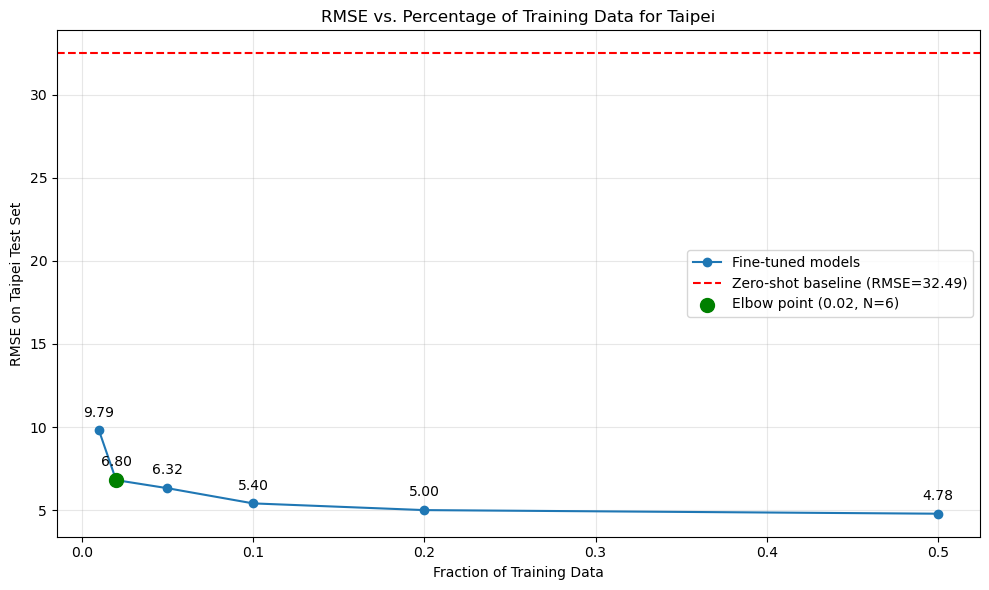

In [112]:
# Plot RMSE vs percentage of training data to find the "elbow" point

# Extract fraction and RMSE values from results
fractions = [r[0] for r in taipei_results]  # Fraction of training data used
rmse_values = [r[2] for r in taipei_results]  # RMSE values

# Add zero-shot baseline
plt.figure(figsize=(10, 6))
plt.plot(fractions, rmse_values, 'o-', label='Fine-tuned models')
plt.axhline(y=rmse_taipei, color='r', linestyle='--', label=f'Zero-shot baseline (RMSE={rmse_taipei:.2f})')

plt.xlabel('Fraction of Training Data')
plt.ylabel('RMSE on Taipei Test Set')
plt.title('RMSE vs. Percentage of Training Data for Taipei')
plt.grid(True, alpha=0.3)
plt.legend()

# Add RMSE annotations
for i, rmse in enumerate(rmse_values):
    plt.annotate(f'{rmse:.2f}', 
                 (fractions[i], rmse_values[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Find the "elbow" point 
if len(fractions) >= 3:
    slopes = [rmse_values[i+1] - rmse_values[i] for i in range(len(rmse_values)-1)]
    slope_changes = [abs(slopes[i+1] - slopes[i]) for i in range(len(slopes)-1)]
    if slope_changes:
        elbow_idx = slope_changes.index(max(slope_changes)) + 1
        elbow_fraction = fractions[elbow_idx]
        elbow_N = int(len(accra_train) * elbow_fraction)

        plt.scatter([elbow_fraction], [rmse_values[elbow_idx]], color='green', s=100, 
                   label=f'Elbow point ({elbow_fraction:.2f}, N={elbow_N})', zorder=5)
        plt.legend()

        print(f"The elbow point appears to be at {elbow_fraction:.2f} of training data (N={elbow_N}) with RMSE={rmse_values[elbow_idx]:.2f}")
        print(f"This suggests that using {elbow_fraction:.2%} of training data provides a good trade-off between")
        print(f"model performance and annotation effort for Taipei.")

plt.tight_layout()
plt.show()


In [117]:
# Set fraction and sample
fraction = 0.2
N = int(len(accra_train) * fraction)
sub = accra_train.sample(N, random_state=42)
Xn, yn = df_to_xy(sub)

# Clone and freeze conv blocks
m_accra = tf.keras.models.clone_model(model)
m_accra.set_weights(model.get_weights())
conv_layers = [l for l in m_accra.layers if isinstance(l, tf.keras.layers.Conv2D)]
for l in conv_layers[:2]:
    l.trainable = False

# Compile and train the model
m_accra.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
m_accra.fit(Xn, yn, epochs=10, batch_size=8, verbose=1, sample_weight=np.ones_like(yn)*5)

# Save the model
m_accra.save("accra_fraction_0.2_model.keras")
print("Saved model as accra_fraction_0.2_model.keras")

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 766.3760 - mae: 8.8442
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 341.1639 - mae: 6.9642
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 408.7189 - mae: 7.2998 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 297.5304 - mae: 6.5417 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 332.8963 - mae: 6.4752 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 302.0839 - mae: 6.4305 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 239.6980 - mae: 5.9130 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 278.5869 - mae: 5.8456 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 271.4166 - mae: 5.6731 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 180.0761 - mae: 4.8429 
Saved model as accra_fraction_0.2_model.keras


In [118]:
# Set fraction and sample
fraction = 0.02
N = int(len(taipei_train) * fraction)
sub = taipei_train.sample(N, random_state=42)
Xn, yn = df_to_xy(sub)

# Clone and freeze conv blocks
m_taipei = tf.keras.models.clone_model(model)
m_taipei.set_weights(model.get_weights())
conv_layers = [l for l in m_taipei.layers if isinstance(l, tf.keras.layers.Conv2D)]
for l in conv_layers[:2]:
    l.trainable = False

# Compile and train the model
m_taipei.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
m_taipei.fit(Xn, yn, epochs=10, batch_size=8, verbose=1, sample_weight=np.ones_like(yn)*5)

# Save the model
m_taipei.save("taipei_fraction_0.02_model.keras")
print("Saved model as taipei_fraction_0.02_model.keras")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3780.3940 - mae: 21.1717  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 808.5706 - mae: 11.0587
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 569.7552 - mae: 8.8591 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 349.2620 - mae: 6.6545 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 466.1586 - mae: 7.9093  
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 196.1853 - mae: 4.8545 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 189.6104 - mae: 4.7484 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 135.7867 - mae: 3.8993
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 130.8428 - mae: 3.6414 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 116.5998 - mae: 3.4709 
Saved model as taipei_fraction_0.02_model.keras


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Performance of fraction=0.2 model on Delhi + Bangkok:
RMSE: 38.62
MAE: 22.13
R²: 0.39


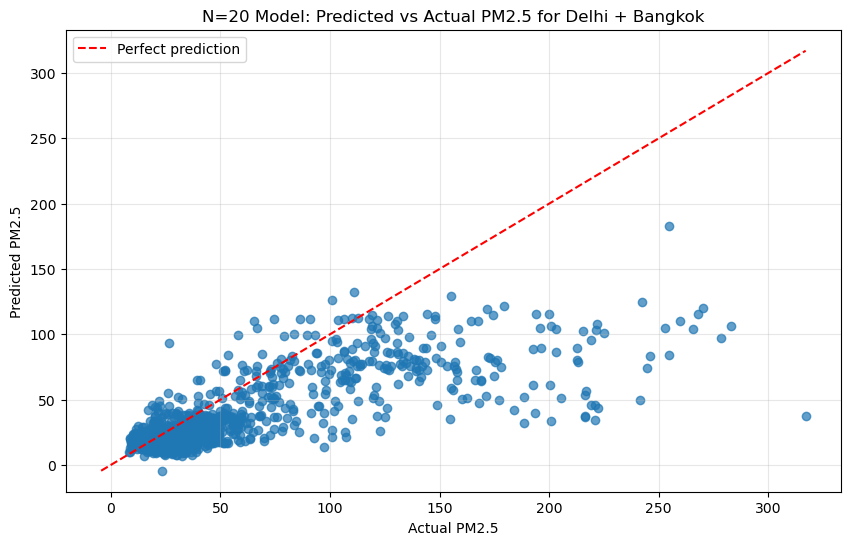

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance of fraction=0.2 model on Delhi only:
RMSE: 64.05
MAE: 45.40
R²: -0.20


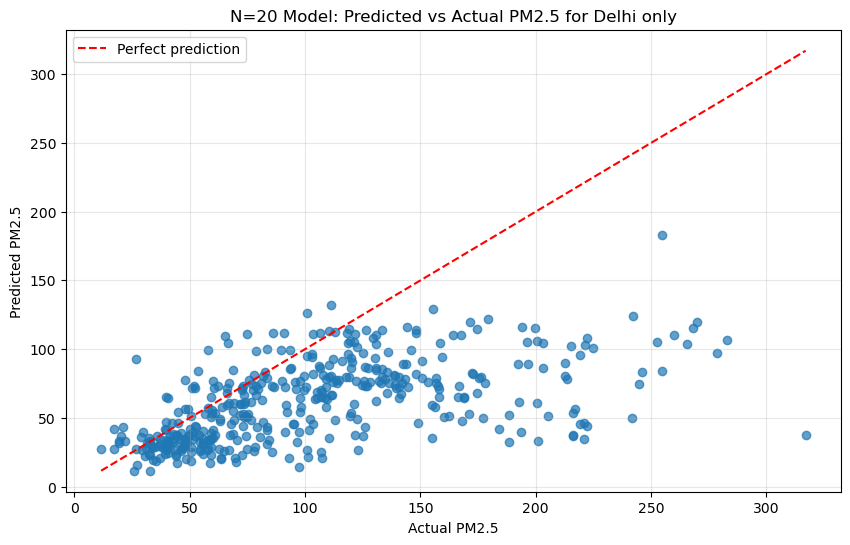

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Performance of fraction=0.2 model on Bangkok only:
RMSE: 13.04
MAE: 10.34
R²: -0.58


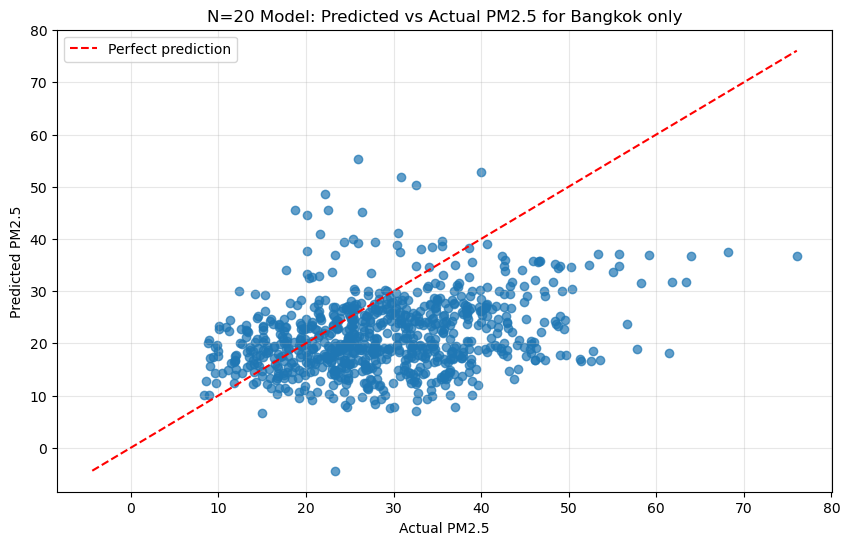

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance of fraction=0.2 model on Taipei only:
RMSE: 17.63
MAE: 13.22
R²: -8.15


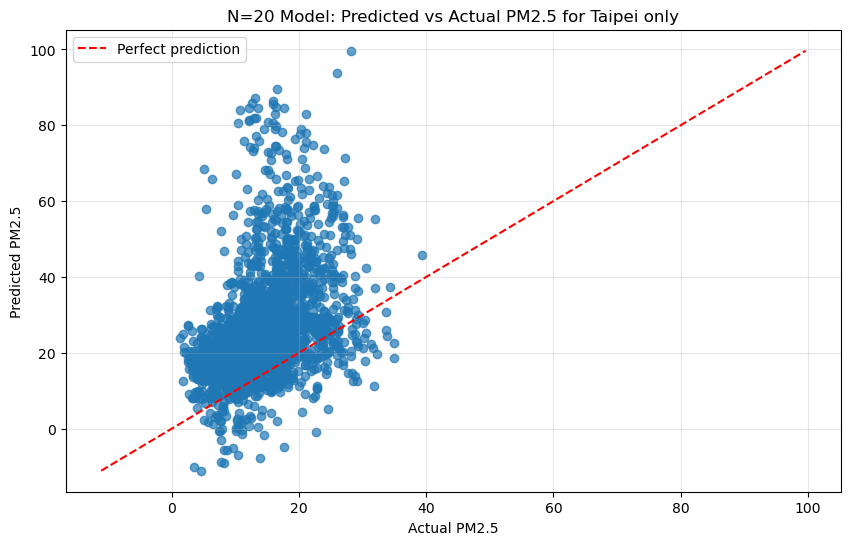

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance of fraction=0.2 model on All Accra:
RMSE: 13.16
MAE: 7.71
R²: 0.06


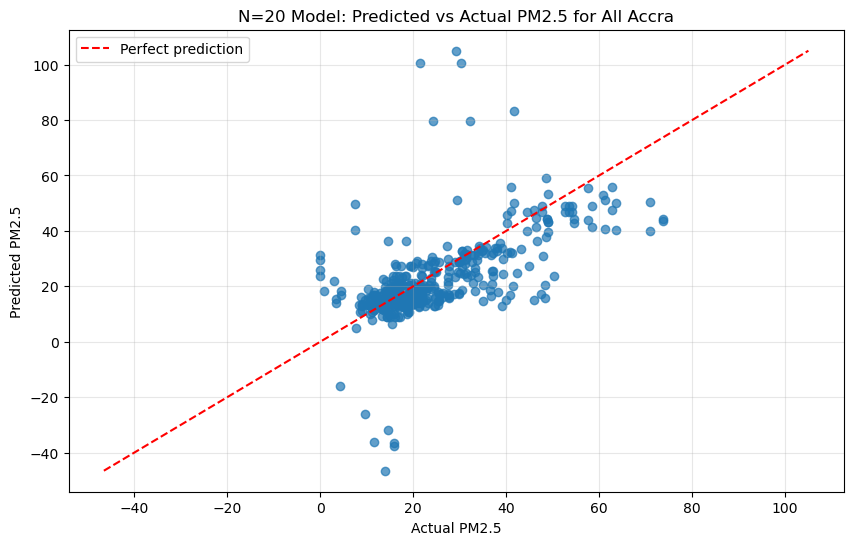

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Performance of fraction=0.2 model on All Lagos:
RMSE: 10.91
MAE: 8.76
R²: -4.68


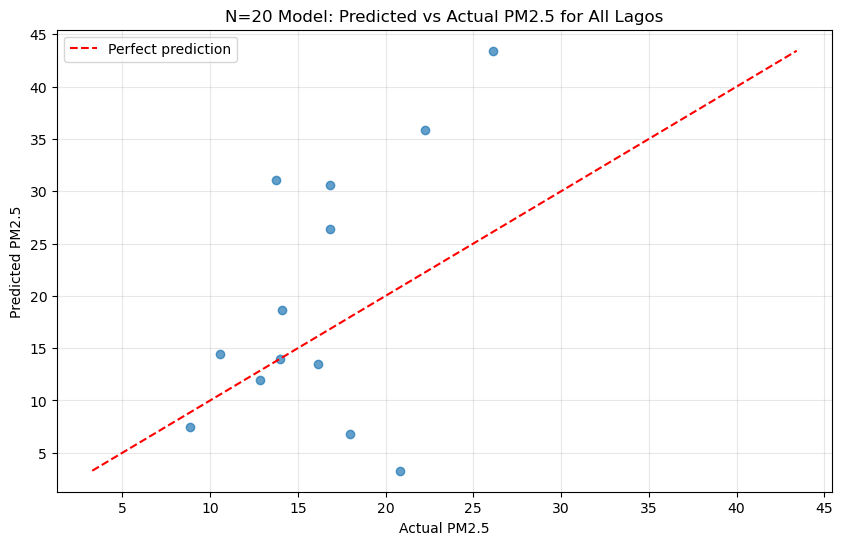

ValueError: All arrays must be of the same length

In [119]:
# Evaluate the fraction = 0.2 model on different datasets
def evaluate_model(model, X, y, dataset_name):
    # Make predictions
    y_pred = model.predict(X).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((y_pred - y) ** 2))
    mae = np.mean(np.abs(y_pred - y))
    r2 = r2_score(y, y_pred)
    
    print(f"\nPerformance of fraction=0.2 model on {dataset_name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.7)
    
    # Add perfect prediction line
    min_val = min(min(y), min(y_pred))
    max_val = max(max(y), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title(f'N=20 Model: Predicted vs Actual PM2.5 for {dataset_name}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return rmse, mae, r2
    
# 1. Evaluate on Hold-out Delhi + Bangkok data
# Combine Delhi and Bangkok data
evaluate_model(m_accra, X_test, y_test, "Delhi + Bangkok")

# 2. Evaluate on Hold-out Delhi only
evaluate_model(m_accra, X_delhi, y_delhi, "Delhi only")
evaluate_model(m_accra, X_bangkok, y_bangkok, "Bangkok only")

# 3. Evaluate on All Taipei
evaluate_model(m_accra, X_taipei, y_taipei, "Taipei only")

# 4. Evaluate on All Accra
evaluate_model(m_accra, X_acc, y_acc, "All Accra")

# 5. Evaluate on All Lagos
evaluate_model(m_accra, X_lagos, y_lagos, "All Lagos")


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Performance of fraction=0.2 model on Delhi + Bangkok:
RMSE: 52.22
MAE: 34.10
R²: -0.11


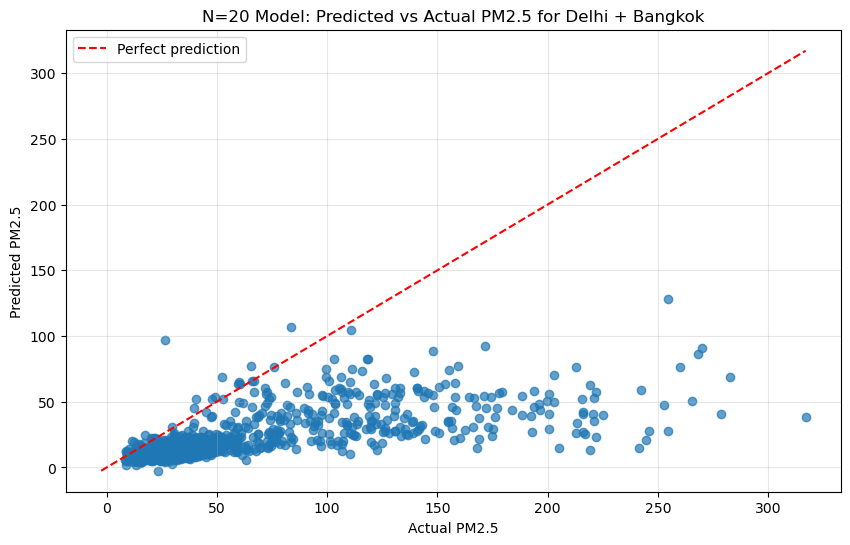

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance of fraction=0.2 model on Delhi only:
RMSE: 85.87
MAE: 67.81
R²: -1.15


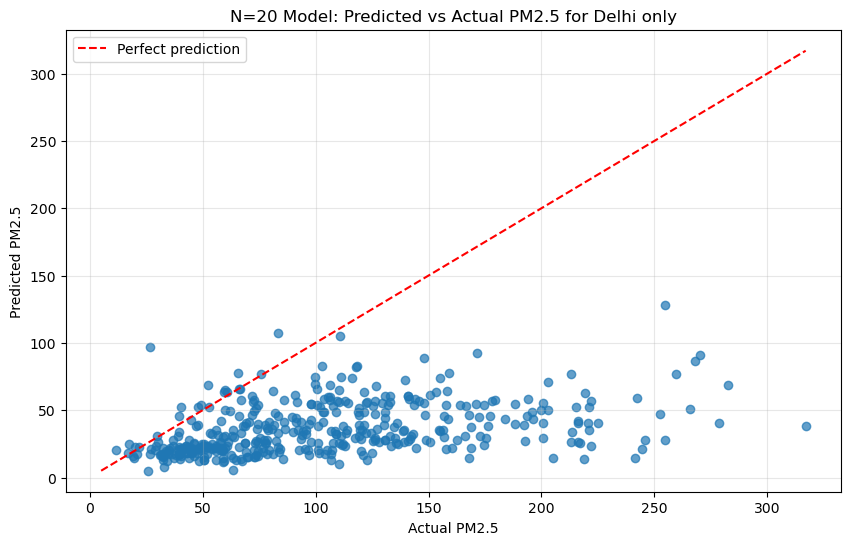

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Performance of fraction=0.2 model on Bangkok only:
RMSE: 19.38
MAE: 17.04
R²: -2.50


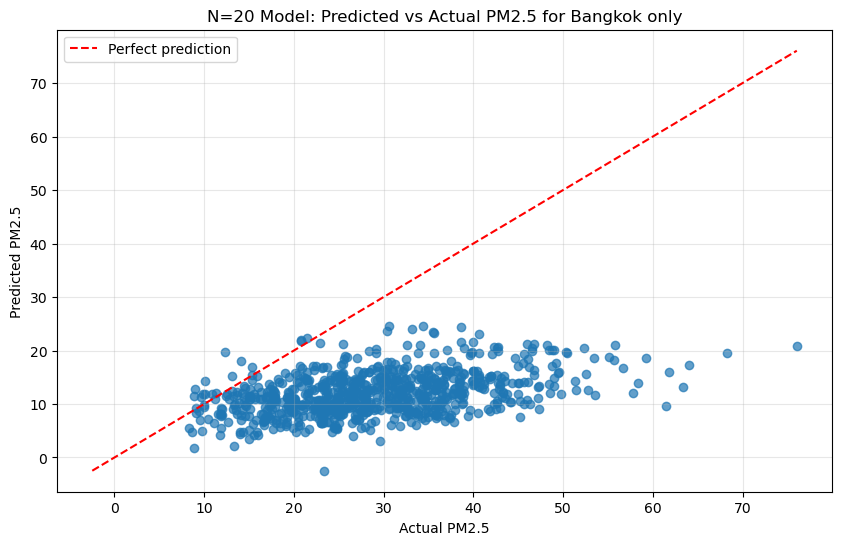

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Performance of fraction=0.2 model on Taipei only:
RMSE: 6.49
MAE: 4.88
R²: -0.24


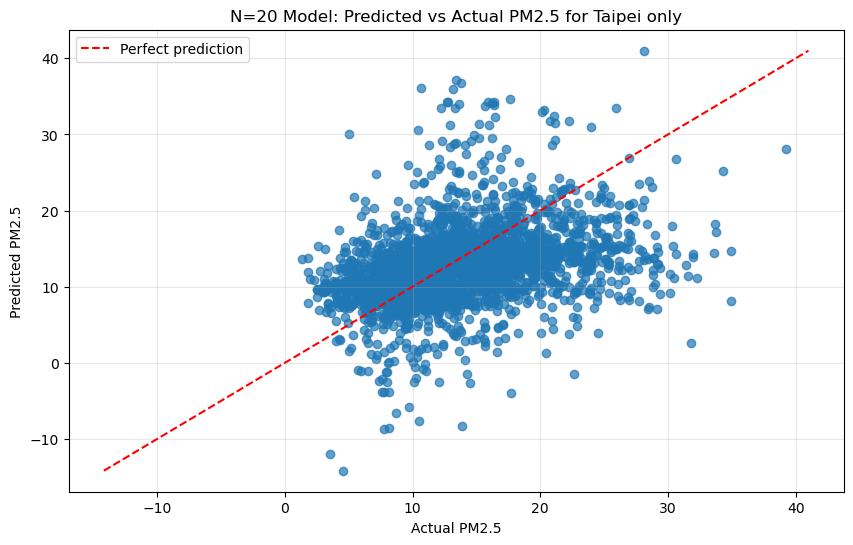

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Performance of fraction=0.2 model on All Accra:
RMSE: 15.84
MAE: 12.55
R²: -0.36


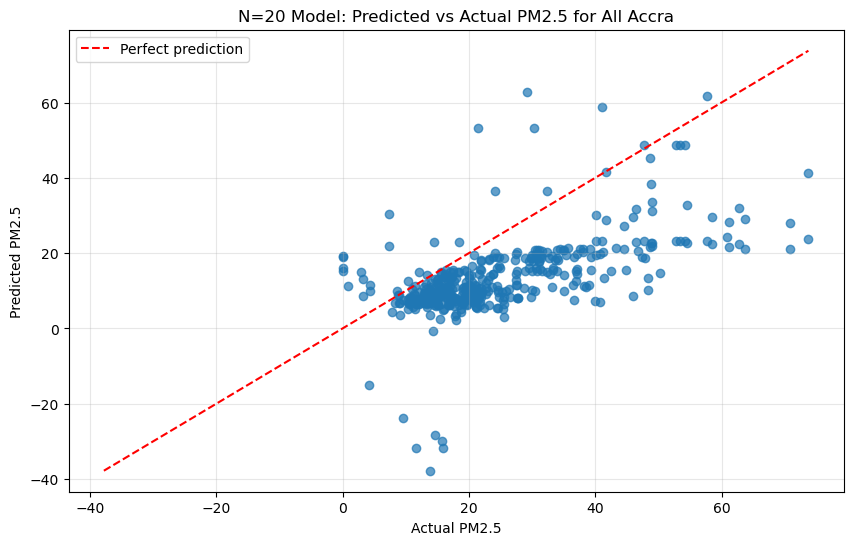

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

Performance of fraction=0.2 model on All Lagos:
RMSE: 8.78
MAE: 6.40
R²: -2.68


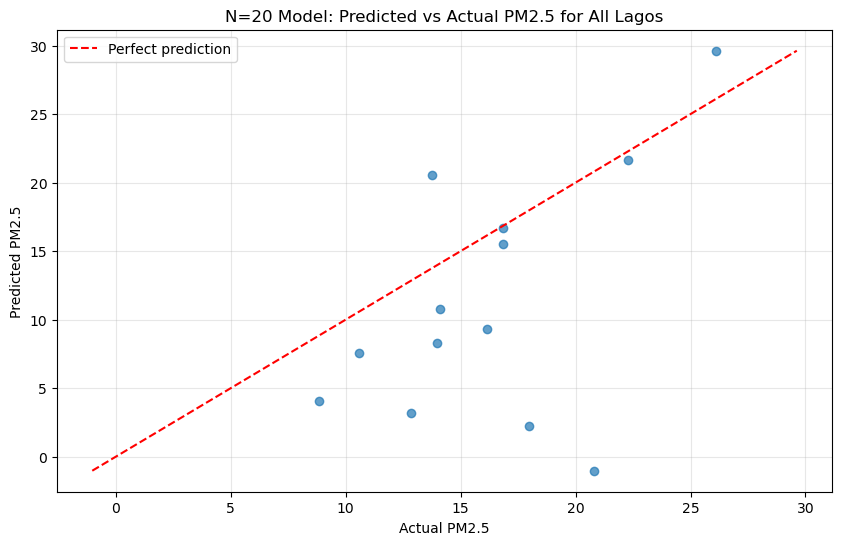

(np.float32(8.776542), np.float32(6.4013114), -2.6752285957336426)

In [120]:
# 1. Evaluate on Hold-out Delhi + Bangkok data
# Combine Delhi and Bangkok data
evaluate_model(m_taipei, X_test, y_test, "Delhi + Bangkok")

# 2. Evaluate on Hold-out Delhi only
evaluate_model(m_taipei, X_delhi, y_delhi, "Delhi only")
evaluate_model(m_taipei, X_bangkok, y_bangkok, "Bangkok only")

# 3. Evaluate on All Taipei
evaluate_model(m_taipei, X_taipei, y_taipei, "Taipei only")

# 4. Evaluate on All Accra
evaluate_model(m_taipei, X_acc, y_acc, "All Accra")

# 5. Evaluate on All Lagos
evaluate_model(m_taipei, X_lagos, y_lagos, "All Lagos")

### Visualize predictions on Lagos

In [47]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
from shapely.geometry import Polygon, Point

In [48]:
def df_to_gdf(df, lon="longitude", lat="latitude", crs="EPSG:4326"):
    """Convert df[lon,lat] to a GeoDataFrame."""
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df[lon], df[lat])],
        crs=crs
    )
    return gdf

In [49]:
def plot_point_map(gdf, val_col="prediction", center=None, zoom=8, title="Predicted PM2.5"):
    # build a linear colormap
    vmin, vmax = float(gdf[val_col].min()), float(gdf[val_col].max())
    cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
    cmap.caption = f"{title} ({val_col})"

    # init map
    if center is None:
        center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
    m = folium.Map(location=center, zoom_start=zoom)

    # add colormap
    m.add_child(cmap)

    # add each point
    for _, row in gdf.iterrows():
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            radius=5,
            fill=True,
            fill_opacity=0.7,
            color=cmap(row[val_col]),
            stroke=False,
        ).add_to(m)

    return m

In [50]:
accra_merged

,sid,week_ms_x,longitude,latitude,patch,city,week_x,week_dt_x,iso_year,iso_week,week_y,pm25_mean,year,week_ms_y,week_dt_y
0,30469,1588550434816,-0.170699,5.579447,"[[[542.0, 1291.0, 0.0, 5653.0], [534.0, 1291.0...",accra,2020-05-04,2020-05-04,2020,19,2020-05-05,18.716667,2020,1588636800000,2020-05-05
1,30469,1589155201024,-0.170699,5.579447,"[[[266.0, 1291.0, 0.0, 5466.0], [280.0, 1291.0...",accra,2020-05-11,2020-05-11,2020,20,2020-05-12,14.754286,2020,1589241600000,2020-05-12
2,30469,1590364864512,-0.170699,5.579447,"[[[0.0, 1291.0, 0.0, 474.0], [0.0, 1291.0, 0.0...",accra,2020-05-25,2020-05-25,2020,22,2020-05-26,15.471429,2020,1590451200000,2020-05-26
3,30469,1595203256320,-0.170699,5.579447,"[[[376.0, 1291.0, -0.5999999642372131, 1835.0]...",accra,2020-07-20,2020-07-20,2020,30,2020-07-21,25.257143,2020,1595289600000,2020-07-21
4,30469,1595808022528,-0.170699,5.579447,"[[[474.5, 1289.0, -0.625, 2536.5], [422.0, 128...",accra,2020-07-27,2020-07-27,2020,31,2020-07-28,19.971429,2020,1595894400000,2020-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,10331002,1734911983616,-0.182020,5.559690,"[[[923.5, 1291.0, 0.0, 1751.0], [917.5, 1291.0...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,44.500000,2024,1734393600000,2024-12-17
424,10331003,1734911983616,-0.172950,5.677900,"[[[948.0, 865.0, 0.0, 3112.5], [912.0, 1282.0,...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,41.075000,2024,1734393600000,2024-12-17
425,10331004,1734911983616,-0.225260,5.558950,"[[[888.0, 1291.0, 0.0, 1846.0], [891.5, 1291.0...",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,63.700000,2024,1734393600000,2024-12-17
426,10331005,1734911983616,-0.248960,5.607240,"[[[908.0, 2633.0, 0.0, 2182.0], [1166.0, 2665....",accra,2024-12-22,2024-12-22,2024,51,2024-12-17,54.525000,2024,1734393600000,2024-12-17


In [51]:
def create_prediction_df(merged_df, model, city_name):
    """
    Create a dataframe with predictions for a city using the trained model.
    
    Args:
        merged_df: DataFrame with patches and ground truth data
        model: Trained TensorFlow model
        city_name: Name of the city (for labeling)
        
    Returns:
        DataFrame with predictions and coordinates
    """
    # Extract patches and make predictions
    X = np.stack(merged_df['patch'].values)
    predictions = model.predict(X).reshape(-1)
    
    # Create a new dataframe with predictions
    pred_df = pd.DataFrame({
        'longitude': merged_df['longitude'],
        'latitude': merged_df['latitude'],
        'prediction': predictions,
        'pm25_mean': merged_df['pm25_mean'],  # Include ground truth if available
        'iso_year': merged_df['iso_year'],
        'iso_week': merged_df['iso_week'],
        'patch': merged_df['patch'],
        'city': city_name
    })
    
    return pred_df

# Create prediction dataframes for Lagos and Accra
lagos_pred_df = create_prediction_df(lagos_merged, model, 'Lagos')
accra_pred_df = create_prediction_df(accra_merged, model, 'Accra')

# Convert to GeoDataFrames for mapping
lagos_gdf = df_to_gdf(lagos_pred_df)
accra_gdf = df_to_gdf(accra_pred_df)

# Display sample of the prediction dataframes
print("Lagos predictions sample:")
display(lagos_pred_df.head())
print("\nAccra predictions sample:")
display(accra_pred_df.head())

# Create maps for both cities
lagos_map = plot_point_map(lagos_gdf, center=[6.5, 3.4], zoom=10, title="Lagos PM2.5")
accra_map = plot_point_map(accra_gdf, center=[5.6, -0.2], zoom=10, title="Accra PM2.5")

# Display the maps
display(lagos_map)
display(accra_map)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Lagos predictions sample:


,longitude,latitude,prediction,pm25_mean,iso_year,iso_week,patch,city
0,3.406815,6.440483,15.957746,20.800000,2023,11,"[[[0.0, 1291.0, 0.0, 557.0], [0.0, 1291.0, 0.0...",Lagos
1,3.406815,6.440483,15.800188,12.854286,2023,25,"[[[0.0, 1291.0, 0.0, 5536.0], [0.0, 1291.0, 0....",Lagos
2,3.406815,6.440483,17.007215,13.972857,2023,33,"[[[0.0, 1291.0, 0.0, 3137.0], [0.0, 1291.0, 0....",Lagos
3,3.406815,6.440483,12.935521,8.831429,2023,34,"[[[0.0, 1291.0, 0.0, 1447.0], [0.0, 1291.0, 0....",Lagos
4,3.406815,6.440483,20.100632,16.148571,2023,38,"[[[0.0, 1291.0, 0.0, 4107.0], [0.0, 1291.0, 0....",Lagos



Accra predictions sample:


,longitude,latitude,prediction,pm25_mean,iso_year,iso_week,patch,city
0,-0.170699,5.579447,19.143541,18.716667,2020,19,"[[[542.0, 1291.0, 0.0, 5653.0], [534.0, 1291.0...",Accra
1,-0.170699,5.579447,22.003637,14.754286,2020,20,"[[[266.0, 1291.0, 0.0, 5466.0], [280.0, 1291.0...",Accra
2,-0.170699,5.579447,14.119393,15.471429,2020,22,"[[[0.0, 1291.0, 0.0, 474.0], [0.0, 1291.0, 0.0...",Accra
3,-0.170699,5.579447,24.040226,25.257143,2020,30,"[[[376.0, 1291.0, -0.5999999642372131, 1835.0]...",Accra
4,-0.170699,5.579447,25.142874,19.971429,2020,31,"[[[474.5, 1289.0, -0.625, 2536.5], [422.0, 128...",Accra


In [52]:
def add_mean_band(df, patch_col="patch", band_idx=0, new_col="mean_AOD"):
    """
    Given df[patch_col] where patch is an array H×W×C,
    extract channel `band_idx` (0 for AOD) and compute its mean.
    """
    df = df.copy()
    df[new_col] = df[patch_col].apply(lambda p: float(np.nanmean(p[..., band_idx])))
    return df

# compute mean AOD on both
accra_gdf = add_mean_band(accra_gdf, band_idx=0, new_col="mean_AOD")
lagos_gdf = add_mean_band(lagos_gdf, band_idx=0, new_col="mean_AOD")


In [53]:
plot_point_map(accra_gdf, val_col="mean_AOD", zoom=9, title="Accra mean AOD")
plot_point_map(lagos_gdf, val_col="mean_AOD", zoom=9, title="Lagos mean AOD")

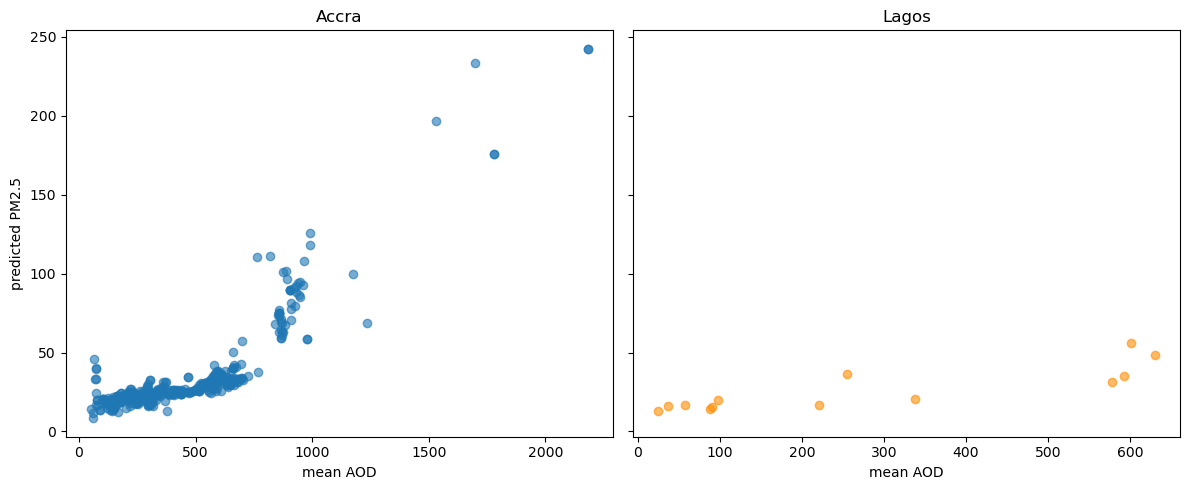

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].scatter(accra_gdf["mean_AOD"], accra_gdf["prediction"], alpha=0.6)
axes[0].set_title("Accra")
axes[0].set_xlabel("mean AOD")
axes[0].set_ylabel("predicted PM2.5")

axes[1].scatter(lagos_gdf["mean_AOD"], lagos_gdf["prediction"], alpha=0.6, color="darkorange")
axes[1].set_title("Lagos")
axes[1].set_xlabel("mean AOD")

plt.tight_layout()
plt.show()


In [55]:
PATCH_KM = 32
HALF_KM = PATCH_KM / 2.0
KM2DEG = 1/111.0
HALF_DEG_LAT = HALF_KM * KM2DEG  # ≃0.144°